## 2. PCA for Eigenfaces
* Reference: 
  * https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/ 

In [5]:
import cv2
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pandas as pd
from sklearn.neighbors import NearestNeighbors

plt.rcParams['text.color'] = 'gray'
plt.rcParams['axes.labelcolor'] = 'gray'
plt.rcParams['image.cmap'] = 'gray'
size_unit = 2

In [83]:
def p2_read(dirpath='p2_data', n_persons=40, n_images=10, n_train=6, n_test=4, shuffle=False):
    # read images
    person_imgs, person_clss = [], []
    for i in range(n_persons):
        imgs, clss = [], []
        for j in range(n_images):
            imgs += [cv2.imread(osp.join(dirpath, "{:d}_{:d}.png".format(i + 1, j + 1)), 0)]
            clss += [i]
        person_imgs += [imgs]
        person_clss += [clss]
    person_imgs = np.array(person_imgs)
    person_clss = np.array(person_clss)
    
    # split training / testing
    indices = np.arange(n_train + n_test)
    if shuffle:
        np.random.shuffle(indices)
    train_indices, test_indices = indices[:n_train], indices[-n_test:]
    
    return person_imgs[:, train_indices], person_clss[:, train_indices], person_imgs[:, test_indices], person_clss[:, test_indices]

In [84]:
def err_cnt(y1, y2):
    return np.sum(np.sign(np.abs(y1 - y2)))


def pca(XT_raw):
    XT_mean = np.mean(XT_raw, axis=0)
    XT = XT_raw - XT_mean
    U, Sigma, VT = np.linalg.svd(XT, full_matrices=False)
    #XT_mean, VT = cv2.PCACompute(XT, mean=XT_mean.reshape(1, -1), maxComponents=n_persons * n_images)
    #print('XT = U * Sigma * VT:', XT.shape, U.shape, Sigma.shape, VT.shape)
    return XT, XT_mean, VT


def knn(k, points, Y, test_points):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(test_points)
    neighbors_Y, vote_Y= Y[indices], []
    for neighbors in neighbors_Y:
        vote_Y += [np.argmax(np.bincount(neighbors))]
    return np.array(vote_Y)

In [135]:
def p2(person_imgs_train, person_clss_train, person_imgs_test, person_clss_test, test=False):
    n_persons, n_images, h, w = person_imgs_train.shape
    XT_raw = person_imgs_train.reshape((n_persons * n_images, -1))
    XT, XT_mean, VT = pca(XT_raw)
    Y = person_clss_train.flatten()
    
    display(Markdown('### 2.1.'))
    rows, cols = 1, 5
    fig, ax = plt.subplots(rows, cols, figsize=(cols * size_unit, rows * size_unit))
    
    for i in range(5):
        if i == 0:
            ax[i].imshow(XT_mean.reshape((h, w)))
            ax[i].set_title("Mean Face")
        else:
            ax[i].imshow(VT[i-1].reshape((h, w)))
            ax[i].set_title("Eigenface {:d}".format(i))

    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.25, wspace=0.25)
    plt.setp(ax, xticks=[], yticks=[]); plt.show()
    
    # test 100 eigenfaces
    if test:
        rows, cols = 10, 10
        fig, ax = plt.subplots(rows, cols, figsize=(cols * size_unit, rows * size_unit))        
        
        for i in range(100):
            r, c = int(i / 10), int(i % 10)
            ax[r, c].imshow(VT[i].reshape((h, w)))
            ax[r, c].set_title("{:d}".format(i + 1))
            
        plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.25, wspace=0.25)
        plt.setp(ax, xticks=[], yticks=[]); plt.show()

    display(Markdown('### 2.2. 2.3.'))
    rows, cols = 1, 5
    fig, ax = plt.subplots(rows, cols, figsize=(cols * size_unit, rows * size_unit))
    original_img = XT[0]
    n_eigenfaces = [3, 45, 140, 229, len(VT)]
    
    for i, n in enumerate(n_eigenfaces):
        projection_T = np.dot(original_img, VT[:n].T)
        reconstruction_T = np.dot(projection_T, VT[:n])
        mse = np.mean((original_img - reconstruction_T) ** 2)
        ax[i].imshow(reconstruction_T.reshape((h, w)))
        ax[i].set_title("n={:d}".format(n))
        ax[i].set_xlabel('mse={:.2f}'.format(mse))
        
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.25, wspace=0.25)
    plt.setp(ax, xticks=[], yticks=[]); plt.show()
        
    display(Markdown('### 2.4.'))
    m_fold_cross_validation = 3
    fold_size = int(n_images / m_fold_cross_validation)
    indices = np.arange(n_images)
    
    n_eigenfaces = [3, 45, 140]
    k_nearest_neighbors = [1, 3, 5]
    errors = np.zeros((len(n_eigenfaces), len(k_nearest_neighbors)))
    
    for m in range(m_fold_cross_validation):
        # split train / validation to each person, not to all images (XT)
        train_indices, val_indices = indices[fold_size:], indices[:fold_size]
        XT_raw_train = person_imgs_train[:, train_indices].reshape((n_persons * len(train_indices), -1))
        XT_raw_val   = person_imgs_train[:, val_indices].reshape((n_persons * len(val_indices), -1))
        Y_train = person_clss_train[:, train_indices].flatten()
        Y_val   = person_clss_train[:, val_indices].flatten()
        # compute eigenfaces by training data
        XT_train, XT_train_mean, VT_train = pca(XT_raw_train)
        
        for i, n in enumerate(n_eigenfaces):
            # project training and validation data onto eigen space
            V_train = VT_train[:n].T
            PT_train = np.dot(XT_train, V_train)
            PT_val = np.dot(XT_raw_val - XT_train_mean, V_train)
            
            for j, k in enumerate(k_nearest_neighbors):
                # find k-nearest-neighbors for each validation data
                Y_val_pred = knn(k, PT_train, Y_train, PT_val)
                err_val = err_cnt(Y_val_pred, Y_val)
                #print('fold={:d}, #eigenfaces={:d}, #neighbors={:d}, err={:d}'.format(m, n, k, err_val))
                errors[i, j] += err_val
                
        indices = np.roll(indices, -fold_size)
    
    display(Markdown('* Error Count'))
    errors = errors / m_fold_cross_validation
    display(pd.DataFrame(np.round(errors, 2), index=['n=%d' % n for n in n_eigenfaces], columns=['k=%d' % k for k in k_nearest_neighbors]))
    display(Markdown('* Accuracy'))
    accuracy = 1 - errors / len(Y_val)
    display(pd.DataFrame(np.round(accuracy, 4), index=['n=%d' % n for n in n_eigenfaces], columns=['k=%d' % k for k in k_nearest_neighbors]))
    
    best_n, best_k = np.where(errors == np.min(errors))
    best_n, best_k = n_eigenfaces[best_n[0]], k_nearest_neighbors[best_k[0]]
    display(Markdown('* Best $(n, k)$ = $({:d}, {:d})$'.format(best_n, best_k)))
    
    display(Markdown('### 2.5.'))
    n_persons_test, n_images_test, _, _ = person_imgs_test.shape
    XT_raw_test = person_imgs_test.reshape((n_persons_test * n_images_test, -1)) # reshape test data
    Y_test = person_clss_test.flatten() # gt of test data
    
    XT_train, XT_train_mean, VT_train = pca(XT_raw) # compute eigenfaces from training data
    PT = np.dot(XT, VT_train[:best_n].T) # project to eigen space
    PT_test = np.dot(XT_raw_test - XT_train_mean, VT_train[:best_n].T) # project to eigen space
    
    Y_test_pred = knn(best_k, PT, Y, PT_test)
    err_test = err_cnt(Y_test_pred, Y_test)
    display(Markdown(('* Test Error = ${:d}$'.format(err_test))))

### 2.1.

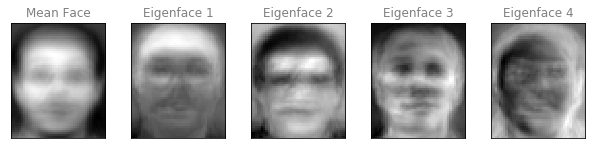

### 2.2. 2.3.

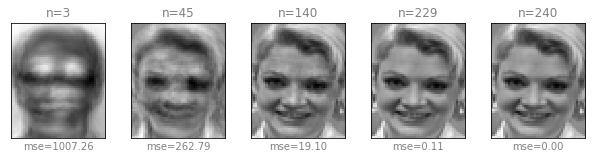

### 2.4.

* Error Count

,k=1,k=3,k=5
n=3,25.67,32.33,38.33
n=45,5.67,13.33,17.33
n=140,5.33,11.67,19.33


* Accuracy

,k=1,k=3,k=5
n=3,0.6792,0.5958,0.5208
n=45,0.9292,0.8333,0.7833
n=140,0.9333,0.8542,0.7583


* Best $(n, k)$ = $(140, 1)$

### 2.5.

* Test Error = $10$

In [136]:
p2_config = {
    'dirpath': 'p2_data', 
    'n_persons': 40,
    'n_images': 10,
    'n_train': 6, 
    'n_test': 4, 
    'shuffle': False
}

p2(*p2_read(**p2_config), test=False)

## 3.

In [137]:
def p3_read(dirpath='p3_data', n_classes=4, n_images=500, n_train=375, n_test=125, shuffle=False):
    # read images
    clss_names = []
    for d in os.listdir(dirpath):
        clss_names += [d] if osp.isdir(osp.join(dirpath, d)) else []
    n_classes = len(clss_names)

    imgs = []
    for c in clss_names:
        clss_imgs = []
        clss_dir = osp.join(dirpath, c)
        for img_fname in np.sort(os.listdir(clss_dir)):
            clss_imgs += [cv2.cvtColor(cv2.imread(osp.join(clss_dir, img_fname)), cv2.COLOR_BGR2RGB)]
        imgs += [clss_imgs]
    
    imgs = np.array(imgs)
    clss = np.repeat(np.arange(n_classes), n_images).reshape(n_classes, -1)
    
    # split training / testing
    indices = np.arange(n_train + n_test)
    if shuffle:
        np.random.shuffle(indices)
    train_indices, test_indices = indices[:n_train], indices[-n_test:]
    
    return imgs[:, train_indices], imgs[:, test_indices], clss[:, train_indices], clss[:, test_indices], clss_names    

In [138]:
X_train, X_test, Y_train, Y_test, class_names = p3_read()

In [153]:
def split_patches(X, p_rows=4, p_cols=4, test=False):
    n_classes, n_images, h, w, channel = X.shape
    ph, pw = int(h / p_rows), int(w / p_cols)
    X_patches = []
    
    for r in range(p_rows):
        for c in range(p_cols):
            X_patches += [X[:, :, r*ph:(r+1)*ph, c*pw:(c+1)*pw]]
    X_patches = np.swapaxes(np.swapaxes(np.array(X_patches), 0, 2), 0, 1)

    if test:
        print(X_patches.shape)
        fig, ax = plt.subplots(p_rows, p_cols, figsize=(8, 8))
        for r in range(p_rows):
            for c in range(p_cols):
                ax[r, c].imshow(X_patches[0, 0, r * p_rows + c])
        plt.show()
    
    return X_patches

def p3(X_train, X_test, Y_train, Y_test, class_names):
    # split patches
    X_train_patches = split_patches(X_train, 4, 4, test=False)
    X_test_patches = split_patches(X_test, 4, 4, test=False)
    
    display(Markdown('## 3.1.'))
    n_classes, n_train, n_patches, h, w, channel = X_train_patches.shape
    rows, cols = 5, 3
    fig, ax = plt.subplots(rows, cols, figsize=(cols * size_unit, rows * size_unit))
    np.random.seed(1028)
    
    for r in range(rows):
        ci = r % n_classes # class index
        ii = np.random.randint(n_train) # image index
        img_patches = X_train_patches[ci, ii]
        img_patch_indices = np.arange(n_patches)
        np.random.shuffle(img_patch_indices)
        
        for c in range(cols):
            pi = img_patch_indices[c]
            ax[r, c].imshow(img_patches[pi])
            ax[r, c].set_title('{}-{:d}-{:d}'.format(class_names[ci], ii, pi))
    
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.2, wspace=0.3)
    plt.setp(ax, xticks=[], yticks=[]); plt.show()
    
    display(Markdown('## 3.2.'))
    n_classes, n_train, n_patches, h, w, channel = X_train_patches.shape
    X_train_flatten = X_train_patches.reshape(n_classes * n_train * n_patches, h * w * channel)
    
    print(X_train_flatten.shape)


## 3.1.

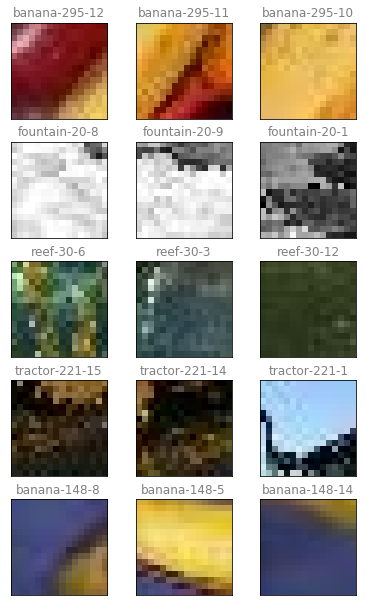

## 3.2.

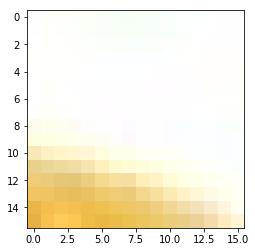

(24000, 768)


In [154]:
p3(X_train, X_test, Y_train, Y_test, class_names)